In [1]:
import torch
import numpy
import matplotlib.pyplot as plt

from dataset_mnist import *
from augmentations import *
from cnn_model     import *
from umap_projection import *


## dataset

sample random batch x, y = dataset.get_batch(batch_size),

x input with shape (batch_size, 1, 28, 28)

y labels with shape (batch_size, ) (not used)

execute two sets of augmentation and plot augmented example

## augmentations

aditive gaussian noise

random color inversion (negative)

random pixel zeroing

x =  torch.Size([256, 1, 28, 28]) tensor(0.1299) tensor(0.3072) tensor(1.)


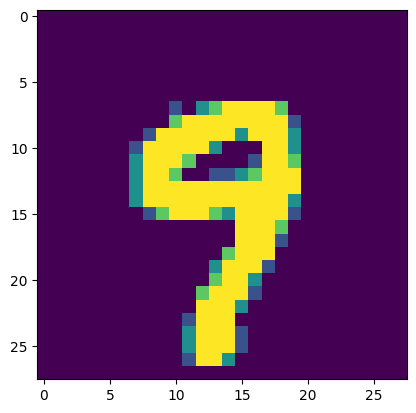

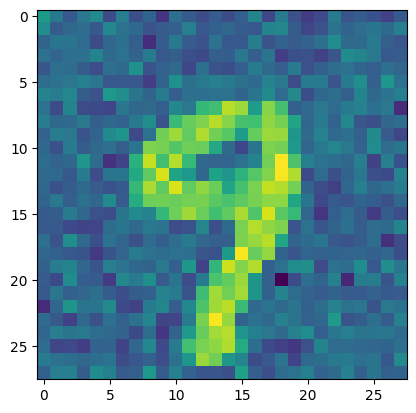

In [2]:
dataset = DatasetMnist()
batch_size = 256    

x, y = dataset.get_batch(batch_size)

print("x = ", x.shape, x.mean(), x.std(), x.max())

x_orig   = x
    
#add noise
x_noised = aug_noise(x_orig)

plt.imshow(x[0][0].detach().cpu().numpy())
plt.show()
plt.imshow(x_noised[0][0].detach().cpu().numpy())
plt.show()


## vicreg loss - non contrastive self supervised loss

- similarity, sim_loss : makes same inputs close
- variance, std_za, std_za : batch-wise variance, prevent collapsing, forces model to generate unique features for every different input
- covariance, cov_za, cov_zb : element-wise (feature-wise) decorrelation, forces model to generate unique features - output from model within single input are not correlate, a.k.a : each features output (each of 256 signals) gives unique infomation


In [3]:
def simclr_loss_func(za, zb):
    batch_size = za.shape[0]    

    # create the similarity matrix
    sim_matrix = torch.mm(za, zb.T)/za.shape[-1]

    target = torch.zeros(batch_size, batch_size)
    target[0:batch_size//2, 0:batch_size//2] = 1.0
    target[batch_size//2:, batch_size//2:] = 1.0

    loss = ((target - sim_matrix)**2).mean()

    return loss


def _off_diagonal(x):
    mask = 1.0 - torch.eye(x.shape[0], device=x.device)
    return x*mask 

def vicreg_loss_func(za, zb): 
    # invariance loss
    sim_loss = ((za - zb)**2).mean()

    # variance loss
    std_za = torch.sqrt(za.var(dim=0) + 1e-6)
    std_zb = torch.sqrt(zb.var(dim=0) + 1e-6) 
    
    std_loss = torch.mean(torch.relu(1.0 - std_za)) 
    std_loss+= torch.mean(torch.relu(1.0 - std_zb))
   
    # covariance loss 
    za_norm = za - za.mean(dim=0)
    zb_norm = zb - zb.mean(dim=0)
    cov_za = (za_norm.T @ za_norm) / (za.shape[0] - 1.0)
    cov_zb = (zb_norm.T @ zb_norm) / (zb.shape[0] - 1.0)
    
    cov_loss = _off_diagonal(cov_za).pow_(2).sum()/za.shape[1] 
    cov_loss+= _off_diagonal(cov_zb).pow_(2).sum()/zb.shape[1]

    # total vicreg loss
    loss = 1.0*sim_loss + 1.0*std_loss + (1.0/25.0)*cov_loss

    return loss






def dist_loss_func(za, zb, k = 5): 
    # similarity loss
    similarity_matrix = torch.nn.functional.cosine_similarity(za.unsqueeze(1), zb.unsqueeze(0), dim=-1)

    _, indices = similarity_matrix.topk(k, dim=-1)

    batch_size = za.shape[0]

    similarity_target = torch.zeros_like(similarity_matrix)
    similarity_target[torch.arange(batch_size).unsqueeze(1), indices] = 1.0

    sim_loss = ((similarity_target - similarity_matrix)**2).mean()
    sim_loss = sim_loss.mean()
    
    

    # variance loss
    std_za = torch.sqrt(za.var(dim=0) + 1e-6)
    std_zb = torch.sqrt(zb.var(dim=0) + 1e-6) 
    
    std_loss = torch.mean(torch.relu(1.0 - std_za)) 
    std_loss+= torch.mean(torch.relu(1.0 - std_zb))
   
    # covariance loss 
    za_norm = za - za.mean(dim=0)
    zb_norm = zb - zb.mean(dim=0)
    cov_za = (za_norm.T @ za_norm) / (za.shape[0] - 1.0)
    cov_zb = (zb_norm.T @ zb_norm) / (zb.shape[0] - 1.0)
    
    cov_loss = _off_diagonal(cov_za).pow_(2).sum()/za.shape[1] 
    cov_loss+= _off_diagonal(cov_zb).pow_(2).sum()/zb.shape[1]

    # total vicreg loss
    loss = 1.0*sim_loss + 1.0*std_loss + (1.0/25.0)*cov_loss

    return loss







## training loop

In [ ]:

loss_functions = [simclr_loss_func, vicreg_loss_func]

n_features = 128    


# train by all loss functions in lsit
for loss_func in loss_functions:
    # create model and optimizer
    model     = Model(dataset.input_shape, n_features)
    print("\n\n")
    print("starting training with loss ", loss_func)
    print(model)


    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    steps_count = len(dataset)//batch_size
    for i in range(steps_count):

        #get random batch
        xa, _      = dataset.get_batch(batch_size)
        xa_noised  = aug_noise(xa)

        xb, _      = dataset.get_batch(batch_size)
        xb_noised  = aug_noise(xb)

        xa = torch.concatenate([xa, xa_noised], dim=0)
        xb = torch.concatenate([xb, xb_noised], dim=0)

        #obtain features
        za = model(xa)
        zb = model(xb)
        
        #compute loss
        loss = loss_func(za, zb)

        #optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(i, steps_count, loss) 

    result_name = str(loss_func.__name__)
    torch.save(model.state_dict(), "trained/" + result_name + ".pt")


print("training done")





starting training with loss  <function simclr_loss_func at 0x325df61f0>
Model(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): SiLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): SiLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=128, bias=True)
  )
)


## features projection

2D visualisation of trained feature space

sample random batch
use UMAP and T-SNE to project 128D space into 2D
plot it, with coloring by class ID

Model(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): SiLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): SiLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=128, bias=True)
  )
)


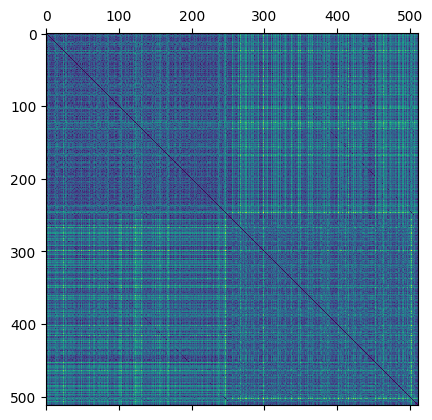

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


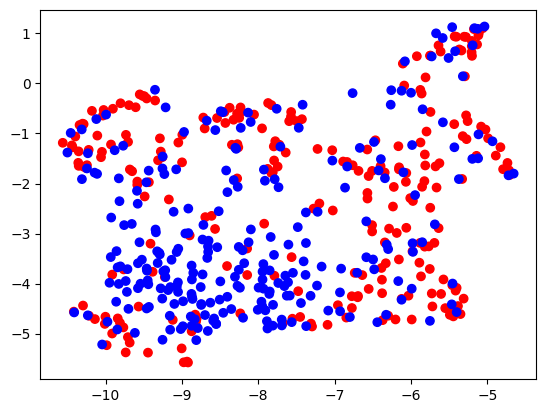

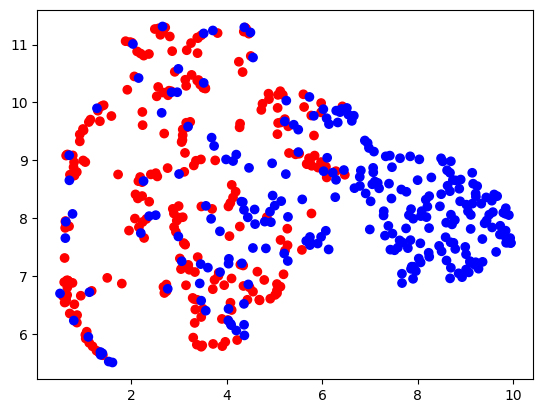

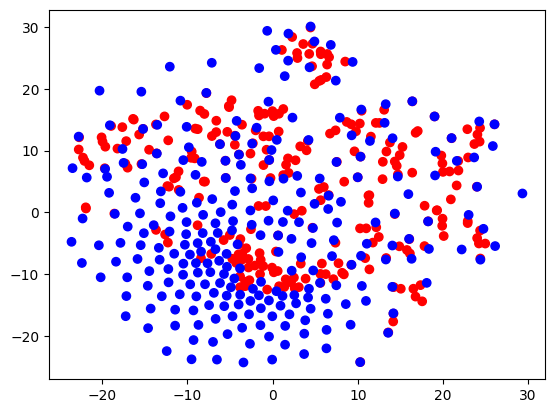

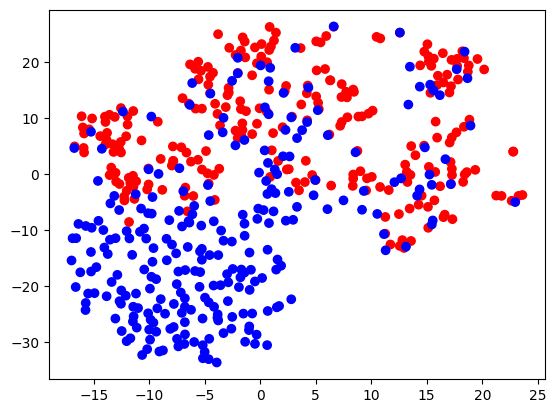

In [5]:

result_name = str(loss_functions[1].__name__)

model = Model(dataset.input_shape, n_features)

model.load_state_dict(torch.load("trained/" + result_name + ".pt", map_location = "cpu"))

print(model)


x, y      = dataset.get_batch(batch_size)
x_noised  = aug_noise(x.clone())

x = torch.concatenate([x, x_noised], dim=0)
y = torch.concatenate([torch.zeros((batch_size, )), torch.ones((batch_size, ))], dim=0)


y = y.detach().cpu().numpy()
y = numpy.array(y, dtype=int)


z = model(x) 
dist = torch.cdist(z, z)
z = z.detach().cpu().numpy()

x = x.flatten(1).detach().cpu().numpy()

plt.matshow(dist.detach().cpu().numpy())
plt.show()

umap_projection(x, y)
umap_projection(z, y)
tsne_projection(x, y)
tsne_projection(z, y)